# Portfolio Optimization

In [1]:
import numpy as np
import pandas as pd 
from scipy.linalg import eigh, cholesky
from scipy.stats import norm
from matplotlib import pyplot as plt 
plt.style.use('seaborn')
from src import optimize
from src.portfolio import Portfolio



def gen_industry_stocks(n_stocks, market, industry, industry_name, sigma_noise, p_year=250):
    mu = pd.Series(np.random.uniform(low=-0.2, high=0.2, size=n_stocks))/p_year
    beta_market = pd.Series(np.random.uniform(low=0.5, high=2.0, size=n_stocks))
    beta_industry = pd.Series(np.random.uniform(low=0.5, high=2.0, size=n_stocks))
    stocks = pd.DataFrame()

    for i in range(n_stocks):
        stocks[f'{industry_name}_stock_{i}'] = mu[i] + beta_market[i]*market + beta_industry[i]*industry + norm.rvs(size=(1, num_samples))[0]*sigma_noise
    mu.index = stocks.columns
    return stocks, mu, beta_market, beta_industry

def information_ratio(equity_curve, p_year=250):
    return equity_curve.mean()/equity_curve.std()*p_year**0.5



p_year = 250
num_samples = p_year*4

sigma_market = 0.1/p_year**0.5
sigma_banks = 0.1/p_year**0.5
sigma_oil = 0.14/p_year**0.5
sigma_insurance = 0.07/p_year**0.5
sigma_tech = 0.2/p_year**0.5
sigma_bio = 0.12/p_year**0.5
sigma_pharma = 0.22/p_year**0.5
sigma_auto = 0.05/p_year**0.5
sigma_retail = 0.125/p_year**0.5
sigma_manufacturing = 0.1/p_year**0.5

sigma_noise = 0.1/p_year**0.5


Let's simulate a bunch of stocks belonging to different industries. Each stock is composed of a deterministic trend $\mu$, a loading on the market related stochastic trend $\beta_{market}$ and a loading on the industry specific stochastic trend $\beta_{industry}$. For each stock, $\mu$, $\beta_{market}$, and $\beta_{industry}$ are sampled from a uniform distribution. In the first simulation, I compare a mean-variance optimization with a naive diversification approach where each asset is equally weighted with the sign of the expected value. At this point I should emphasize that I assume perfect knowledge of the expected value. Traditionally, the expected value is estimated by the in-sample first moment of the asset. In my example, this would actually make sense since the mean is a consistent estimator of the deterministic trend. In practice, however, there is probably not a constant deterministic trend. This is where the alpha model steps in, which is not the topic of this study and thus assumed given. 


In [2]:
def plot_equity_curve(log_returns):
    plt.plot(np.exp(log_returns.cumsum()))
    plt.title('Equity Curve')
    plt.xlabel('Period')
    plt.ylabel('Equity Value')
    plt.show()



def show_standard_optimized_equity(n_stocks, industry):
    trainig_pct = 0.5
    n_train = int(trainig_pct*num_samples)
    market = norm.rvs(size=(1, num_samples))[0]*sigma_market
    industries = {}
    
    stocks, mu, beta_market, beta_industry = gen_industry_stocks(n_stocks, market, list(industry.values())[0], list(industry.keys())[0], sigma_noise, p_year)
    plot_equity_curve(stocks)
    weights = optimize.minimize_objective(mu.index,
                                     optimize.negative_sharpe,
                                     True,
                                     (-1, 1),
                                     mu, stocks[:n_train].cov(),
                                     0.0, 0.0,)

    portfolio_sm_is = np.dot(stocks.values,np.array(list(weights.values())))[:n_train]
    IR_ann = information_ratio(portfolio_sm_is)
    print('IR sm_is', IR_ann )
    plot_equity_curve(portfolio_sm_is)
    
    portfolio_equal_is = np.dot(stocks.values,mu.apply(np.sign)/mu.shape[0])[:n_train]
    IR_ann = information_ratio(portfolio_equal_is)
    print('IR equal_is', IR_ann )
    plot_equity_curve(portfolio_equal_is)

    portfolio_sm_oos = np.dot(stocks.values,np.array(list(weights.values())))[n_train:]
    IR_ann = information_ratio(portfolio_sm_oos)
    print('IR sm_oos', IR_ann )
    plot_equity_curve(portfolio_sm_oos)
    
    portfolio_equal_oos = np.dot(stocks.values,mu.apply(np.sign)/mu.shape[0])[:n_train]
    IR_ann = information_ratio(portfolio_equal_oos)
    print('IR equal_is', IR_ann )
    plot_equity_curve(portfolio_equal_oos)
    
    return weights

The results below show that out of sample performance is decent if the number of assets is relatively small. It definently beats equal weighting.

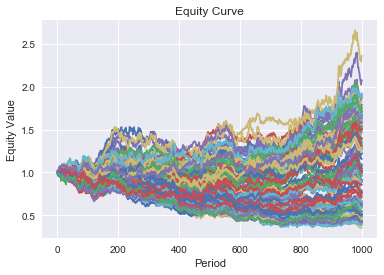

IR sm_is 14.265406555868553


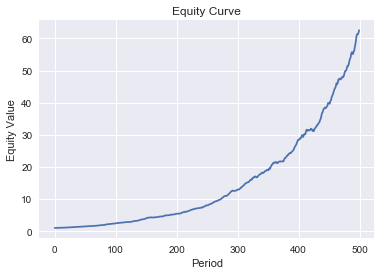

IR equal_is 9.494745163316734


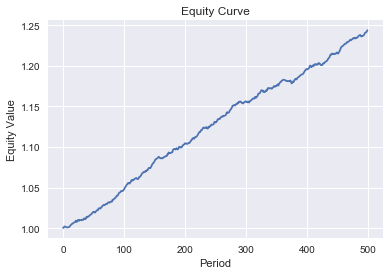

IR sm_oos 10.507909152138048


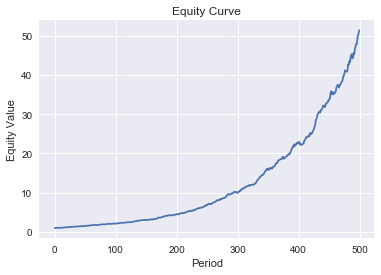

IR equal_is 9.494745163316734


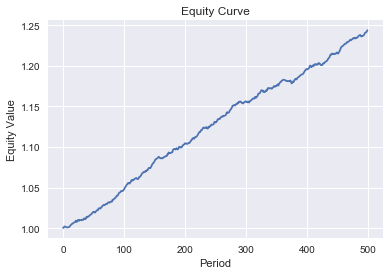

In [3]:
industry = {}
industry['manufacturing'] = norm.rvs(size=(1, num_samples))[0]*sigma_manufacturing
_ = show_standard_optimized_equity(n_stocks=100, industry=industry)

When the number of assets is relatively large, however, the out-of-sample performance is significantly smaller than the in-sample performance as demonstrated by the information ratio (IR). Even the very naive approach of equal weighting beats mean-variance optimization out-of-sample embarrassingly often.

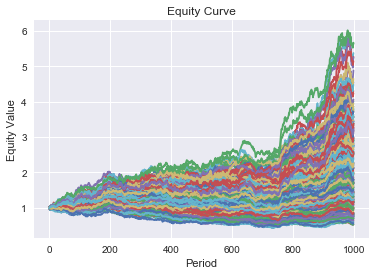

IR sm_is 33.03784451199481


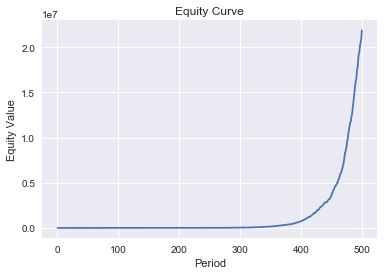

IR equal_is 12.225306082219163


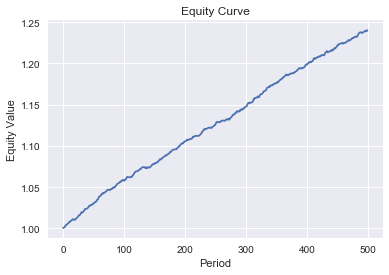

IR sm_oos 13.745139808607446


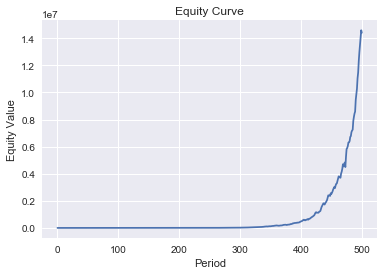

IR equal_is 12.225306082219163


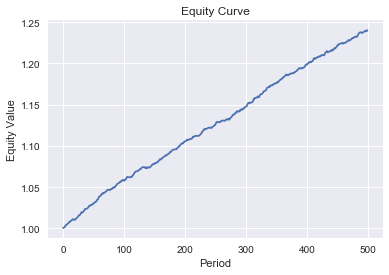

In [4]:
weights = show_standard_optimized_equity(n_stocks=300, industry=industry)

In [5]:
pf = Portfolio(assets=weights.keys(), position=pd.Series(weights), price=[1]*len(weights.keys()))
print(pf)
print('largest long:', pf[0], pf.position(pf[0]))
print('largest short:', pf[-1], pf.position(pf[-1]))

Portfolio: 300 Assets, $42.1 Long, $42.1 Short
largest long: manufacturing_stock_231 0.9993717564131621
largest short: manufacturing_stock_183 -0.8185944617051237


In [6]:
pf.portfolio_df.head()

,position,price,factor_value,sector_id,position_value
manufacturing_stock_231,0.999372,1,1.0,0.0,0.999372
manufacturing_stock_67,0.961860,1,1.0,0.0,0.961860
manufacturing_stock_73,0.914765,1,1.0,0.0,0.914765
manufacturing_stock_164,0.886321,1,1.0,0.0,0.886321
manufacturing_stock_82,0.837675,1,1.0,0.0,0.837675


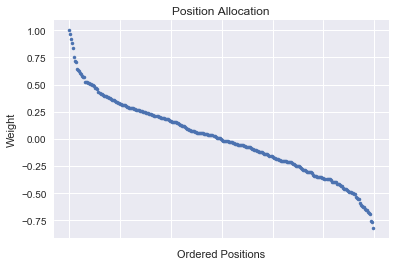

In [7]:
pf.portfolio_df.position_value.plot(style='.')
plt.title('Position Allocation')
plt.xlabel('Ordered Positions')
plt.ylabel('Weight')
plt.show()

Here you can see a typical result of mean-variance optimization. There are some very large positions. These are most likely due to estimation errors of the covariance matrix and thus undesirable. This problem is even greater when $\mu$, too, is estimated with error. As the number of assets grows, there is a higher likelihood of observing an extreme covariance value by chance and thus this problem actually grows with the number of assets. This is so common that it has a name. In the literature it goes by 'Error Maximization'. 


## Imposing Structure

To reduce Error Maximization we need to impose structure. One way to do this is by using our knowledge that stocks usually cluster (e.g., into certain industries). It seems like a good idea to encode this prior knowledge by mean-variance optimize stocks within clusters and then optimize allocation to these clusters. This is pursued next and compared to the standard optimization.

In [8]:
trainig_pct = 0.5
n_train = int(trainig_pct*num_samples)
ir_sm_is = []
ir_sm_oos = []
ir_hier_is = []
ir_hier_oos = []
n_stocks = 50

for j in range(10):
    print('MC run: ', j)
    
    market = norm.rvs(size=(1, num_samples))[0]*sigma_market
    industries = {}
    industries['banks'] =  norm.rvs(size=(1, num_samples))[0]*sigma_banks
    industries['oil'] = norm.rvs(size=(1, num_samples))[0]*sigma_oil
    industries['insurance'] = norm.rvs(size=(1, num_samples))[0]*sigma_insurance
    industries['tech'] = norm.rvs(size=(1, num_samples))[0]*sigma_tech
    industries['bio'] = norm.rvs(size=(1, num_samples))[0]*sigma_bio
    industries['pharma'] = norm.rvs(size=(1, num_samples))[0]*sigma_pharma
    industries['auto'] = norm.rvs(size=(1, num_samples))[0]*sigma_auto
    industries['retail'] = norm.rvs(size=(1, num_samples))[0]*sigma_retail
    
    industries_stocks = {}
    industries_mu = {}
    industries_beta_market = {}
    industries_beta_industries = {}
    industries_weights = {}
    industries_portfolio = {}

    stocks_all = pd.DataFrame()
    expected_returns_all = pd.Series()

    for i in industries.keys():
        industries_stocks[i], industries_mu[i], industries_beta_market[i], industries_beta_industries[i] = gen_industry_stocks(n_stocks, market, industries[i], i, sigma_noise, p_year)
        stocks_all = pd.concat([stocks_all,industries_stocks[i]], axis=1)
        expected_returns_all = expected_returns_all.append(industries_mu[i])

        industries_weights[i] = optimize.minimize_objective(industries_mu[i].index,
                                     optimize.negative_sharpe,
                                     True,
                                     (-1, 1),
                                     industries_mu[i], industries_stocks[i][:n_train].cov(),
                                     0.0, 0.0,)
        industries_portfolio[i] = np.dot(industries_stocks[i].values,np.array(list(industries_weights[i].values())))


    #standard sample moments
    weights = optimize.minimize_objective(expected_returns_all.index,
                                     optimize.negative_sharpe,
                                     True,
                                     (-1, 1),
                                     expected_returns_all, stocks_all[:n_train].cov(),
                                     0.0, 0.0,)
    portfolio_sm_is = np.dot(stocks_all.values,np.array(list(weights.values())))[:n_train]
    IR_ann = information_ratio(portfolio_sm_is)
    ir_sm_is.append(IR_ann)
    print('IR sm_is', IR_ann )

    portfolio_sm_oos = np.dot(stocks_all.values,np.array(list(weights.values())))[n_train:]
    IR_ann = information_ratio(portfolio_sm_oos)
    ir_sm_oos.append(IR_ann)
    print('IR sm_oos', IR_ann )

    # hierarchical
    # optimize allocation to industry
    industry_weights = optimize.minimize_objective(industries.keys(),
                                     optimize.negative_sharpe,
                                     False,
                                     (-1, 1),
                                     pd.Series(index=industries.keys(), data=[0.1]*len(industries.keys())),
                                     pd.DataFrame(industries_portfolio).cov()[:n_train]*100000,
                                     0.0, 0.0,)
#     # equal weighting industries
#     for i in industry_weights.keys():
#         industry_weights[i] = 1/len(industries)

    print(industry_weights)
    portfolio_hier_is = np.dot(pd.DataFrame(industries_portfolio).values,
                            np.array(list(industry_weights.values())))[:n_train]

    IR_ann = information_ratio(portfolio_hier_is)
    print('IR hier is', IR_ann )
    ir_hier_is.append(IR_ann)

    portfolio_hier_oos = np.dot(pd.DataFrame(industries_portfolio).values,
                            np.array(list(industry_weights.values())))[n_train:]

    IR_ann = information_ratio(portfolio_hier_oos)
    print('IR hier oos', IR_ann )
    ir_hier_oos.append(IR_ann)


MC run:  0
IR sm_is 45.792344688925304
IR sm_oos 11.927899981580644
{'banks': 0.16973330597304792, 'oil': 0.04505064637458227, 'insurance': 0.057706983562109175, 'tech': 0.04030888177362566, 'bio': 0.046730958404646784, 'pharma': 0.5524337711635433, 'auto': 0.06704956217830577, 'retail': 0.02098589057013896}
IR hier is 21.681282189331853
IR hier oos 19.224988496160577
MC run:  1
IR sm_is 51.92982821193116
IR sm_oos 10.432989882397973
{'banks': 0.020922596023054664, 'oil': 0.14531174361476507, 'insurance': 0.0374550431082656, 'tech': 0.14298724674197152, 'bio': 0.011878485632665378, 'pharma': 0.49288985121025747, 'auto': 0.12184731446093099, 'retail': 0.026707719208089363}
IR hier is 19.885069377135665
IR hier oos 17.09685200437352
MC run:  2
IR sm_is 44.38495646339378
IR sm_oos 10.342642941380108
{'banks': 0.17872998594799283, 'oil': 0.040209039047470994, 'insurance': 0.08485920753900619, 'tech': 0.10186930312376379, 'bio': 0.190049081022156, 'pharma': 0.21031177437583679, 'auto': 0.10

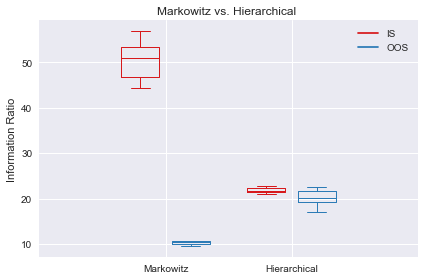

In [9]:
data_a = [ir_sm_is, ir_hier_is]
data_b = [ir_sm_oos, ir_hier_oos]

ticks = ['Markowitz', 'Hierarchical']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)

set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='IS')
plt.plot([], c='#2C7BB6', label='OOS')
plt.legend()
plt.title('Markowitz vs. Hierarchical ')
plt.ylabel('Information Ratio')
plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
# plt.ylim(0, 8)
plt.tight_layout()
# plt.savefig('boxcompare.png')

In [10]:
performance_factor = np.mean(ir_hier_oos)/np.mean(ir_sm_oos)
print('OOS performance gain factor', performance_factor)

OOS performance gain factor 1.9498961628276463


In [11]:
Portfolio?
dir(Portfolio)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'from_dataframe',
 'gross_exposure',
 'long_exposure',
 'long_exposure_pct',
 'longs',
 'net_exposure',
 'position',
 'sector_net_exposures',
 'short_exposure',
 'short_exposure_pct',
 'shorts',
 'trade']

In [12]:
pf = Portfolio(assets=weights.keys(),
               position=pd.Series(weights),
               price=[1]*len(weights.keys()),
               sector_id=pd.Series(list(weights.keys())).str[:3].values
              )
print(pf)
print('largest long:', pf[0], pf.position(pf[0]))
print('largest short:', pf[-1], pf.position(pf[-1]))
pf.sector_net_exposures()

Portfolio: 400 Assets, $49.36 Long, $49.36 Short
largest long: pharma_stock_9 1.0
largest short: oil_stock_37 -0.9443895498712807


,position_value
sector_id,
aut,1.199998
ban,-0.016484
bio,-0.832573
ins,-0.242793
oil,0.901955
pha,0.436897
ret,-0.826920
tec,-0.620080


In [13]:
pf.portfolio_df.head()

,position,price,factor_value,sector_id,position_value
pharma_stock_9,1.000000,1,1.0,pha,1.000000
banks_stock_37,0.958765,1,1.0,ban,0.958765
bio_stock_43,0.807193,1,1.0,bio,0.807193
oil_stock_25,0.778459,1,1.0,oil,0.778459
tech_stock_9,0.734119,1,1.0,tec,0.734119


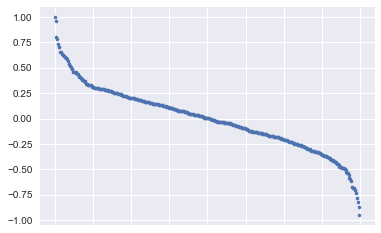

In [14]:
pf.portfolio_df.position_value.plot(style='.')

## Pricipal Component Analysis

Principal Component Analysis (PCA) allows us to reduce the dimension of the covariance matrix. Since the covariance matrix is symmetric we can decompose the matrix into its eigenvalues and eigenvectors. In the simulation we have exposure to the market and several industries. Thus it makes sense to reduce the dimension to the number of these variables. Plotting the proportion of variance explained by the first n principal components confirms this hypothesis.

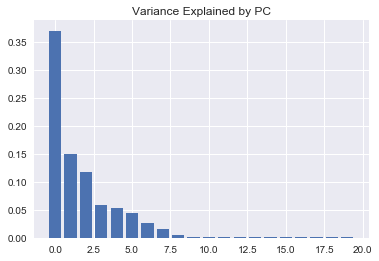

In [15]:
from sklearn.decomposition import PCA as sklearnPCA

n_components = 20
sklearn_pca = sklearnPCA(n_components=n_components) 
pc = sklearn_pca.fit_transform(stocks_all)

plt.bar(range(n_components),sklearn_pca.explained_variance_ratio_)
plt.title('Variance Explained by PC')
plt.show()

In [16]:
cov = stocks_all.cov()
evalues, evectors = np.linalg.eig(cov)
# pr_evalues = np.sort(evalues)[-10:]
n = len(industries)+1
evalues[evalues<evalues[n]] = 0
Q = evectors
R = np.linalg.inv(Q)
L = np.diag(evalues)
pc_cov = pd.DataFrame(Q.dot(L).dot(R))

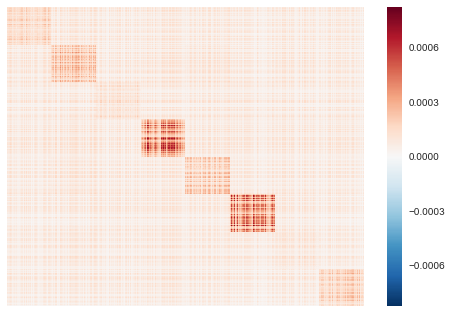

In [17]:
import seaborn as sns
sns.heatmap(pc_cov, xticklabels=False, yticklabels=False)

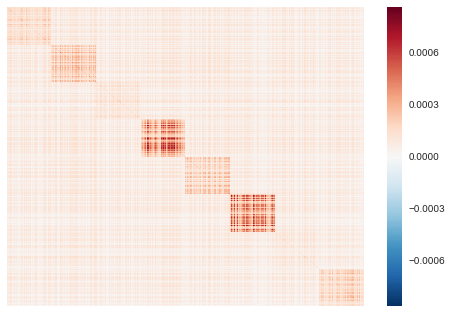

In [18]:
sns.heatmap(cov, xticklabels=False, yticklabels=False)

The heatmaps above look almost indistinguishable after eliminating all other components.


In [19]:
cov = stocks_all[:n_train].cov()

evalues, evectors = np.linalg.eig(cov)
n = 10
evalues[evalues<evalues[n]] = 0
Q = evectors
R = np.linalg.inv(Q)
L = np.diag(evalues)
pc_cov = pd.DataFrame(Q.dot(L).dot(R))


weights = optimize.minimize_objective(expected_returns_all.index,
                                 optimize.negative_sharpe,
                                 True,
                                 (-1, 1),
                                 expected_returns_all, pc_cov,
                                 0.0, 0.0,)

portfolio_sm_is = np.dot(stocks_all.values,np.array(list(weights.values())))[:n_train]
IR_ann = information_ratio(portfolio_sm_is)
ir_sm_is.append(IR_ann)
print('IR sm_is', IR_ann )

portfolio_sm_oos = np.dot(stocks_all.values,np.array(list(weights.values())))[n_train:]
IR_ann = information_ratio(portfolio_sm_oos)
ir_sm_oos.append(IR_ann)
print('IR sm_oos', IR_ann )

IR sm_is 21.637743446366038
IR sm_oos 21.94964550873633


/Users/jan/Documents/PoCon/src/optimize.py:30: UserWarning: Optimizer did not converge.
  warnings.warn("Optimizer did not converge.")


In [20]:
print(np.linalg.matrix_rank(cov))
print(np.linalg.matrix_rank(pc_cov))

400
11


In [21]:
pf = Portfolio(assets=weights.keys(),
               position=pd.Series(weights),
               price=[1]*len(weights.keys()),
               sector_id=pd.Series(list(weights.keys())).str[:3].values
              )
print(pf)
print('largest long:', pf[0], pf.position(pf[0]))
print('largest short:', pf[-1], pf.position(pf[-1]))
pf.sector_net_exposures()

Portfolio: 400 Assets, $114.61 Long, $114.61 Short
largest long: pharma_stock_24 0.8534880688606558
largest short: banks_stock_47 -0.8625501592530984


,position_value
sector_id,
aut,0.055895
ban,1.716196
bio,-2.049116
ins,-0.823077
oil,1.300276
pha,0.791265
ret,-0.247408
tec,-0.744033


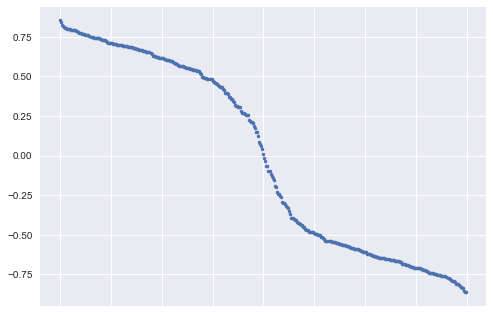

In [22]:
pf.portfolio_df.position_value.plot(style='.')

PCA reduced extreme positions and set a lot fewer weights close to zero.